<a href="https://colab.research.google.com/github/williammcintosh/Portfolio/blob/master/McIntosh_Week05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Exploration 

## Will McIntosh

[Data Dictionary Link](https://www.oregon.gov/ODOT/Data/documents/CDS_Code_Manual.pdf)

In [1]:
import pandas as pd
import sys, os
import matplotlib.pyplot as plt
from tqdm.auto import tqdm # For progress bar

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# downloads the .csv file from google drive only if it's not already in directory
file_path = "/content/bc_trip259172515_230215.csv"
if os.path.isfile(file_path) == False:
  !gdown 1G4MUbdUFeACgjGcg6dcwykBZn21zg1jO

df = pd.read_csv(file_path, low_memory=False)
df.head(10)

,EVENT_NO_TRIP,EVENT_NO_STOP,OPD_DATE,VEHICLE_ID,METERS,ACT_TIME,GPS_LONGITUDE,GPS_LATITUDE,GPS_SATELLITES,GPS_HDOP
0,259172515,259172517,15FEB2023:00:00:00,4223,40,20469,-122.648137,45.493082,12,0.7
1,259172515,259172517,15FEB2023:00:00:00,4223,48,20474,-122.648240,45.493070,12,0.8
2,259172515,259172517,15FEB2023:00:00:00,4223,57,20479,-122.648352,45.493123,12,0.8
3,259172515,259172517,15FEB2023:00:00:00,4223,73,20484,-122.648385,45.493262,12,0.7
4,259172515,259172517,15FEB2023:00:00:00,4223,112,20489,-122.648347,45.493582,12,0.8
5,259172515,259172517,15FEB2023:00:00:00,4223,159,20494,-122.648357,45.494003,11,0.8
6,259172515,259172517,15FEB2023:00:00:00,4223,215,20499,-122.648383,45.494510,12,0.7
7,259172515,259172517,15FEB2023:00:00:00,4223,272,20504,-122.648375,45.495023,12,0.7
8,259172515,259172517,15FEB2023:00:00:00,4223,330,20509,-122.648330,45.495555,12,0.7
9,259172515,259172517,15FEB2023:00:00:00,4223,391,20514,-122.648213,45.496103,12,0.7


## Helper Functions

In [2]:
def missing_data(df):
    """
    Takes an existing dataframe as input and returns a new dataframe with the percentage and count of missing values for each column.
    """
    missing_count = df.isna().sum()  # Get the count of missing values for each column
    missing_pct = missing_count / len(df) * 100  # Calculate the percentage of missing values for each column
    missing_df = pd.concat([missing_count, missing_pct], axis=1, keys=['missing_count', 'missing_pct'])  # Combine the count and percentage into a new dataframe
    missing_df = missing_df[missing_df['missing_count'] > 0]  # Only include columns with missing values
    missing_df.index.name = 'column'  # Set the index name to 'column'
    missing_df = missing_df.sort_values(by='missing_pct', ascending=True)  # Sort by the percentage of missing values in descending order
    return missing_df

In [3]:
def Get_Timestamp(tdf):
  df = tdf.copy(deep=True)

  # convert 'OPD_DATE' column to pandas datetime object
  df['OPD_DATE'] = pd.to_datetime(df['OPD_DATE'], format='%d%b%Y:%H:%M:%S')

  # create a new 'TIMESTAMP' column by adding 'ACT_TIME' as a timedelta object
  df['TIMESTAMP'] = df['OPD_DATE'] + pd.to_timedelta(df['ACT_TIME'], unit='s')

  return df

In [4]:
def Get_Speed(tdf):
  df = tdf.copy(deep=True)
  
  # calculate the SPEED column
  df['SPEED'] = 0  # set the first SPEED value to zero
  for i in range(1, len(df)):
      current_meters = df.at[i, 'METERS']
      previous_meters = df.at[i-1, 'METERS']
      current_timestamp = df.at[i, 'ACT_TIME']
      previous_timestamp = df.at[i-1, 'ACT_TIME']
      speed = (current_meters - previous_meters) / (current_timestamp - previous_timestamp)
      df.at[i, 'SPEED'] = speed

  return df

In [44]:
def Get_Max_Speed_For_ID(tdf, ID):
  return tdf[tdf['VEHICLE_ID']==ID]['SPEED'].max()

In [45]:
def Get_Speed_Date(tdf, ID, max_speed):
  return tdf[(tdf['VEHICLE_ID']==ID) & (tdf['SPEED']==max_speed)]['OPD_DATE']

In [55]:
def Get_Speed_Loc(tdf, ID, max_speed):
  longi = tdf[(tdf['VEHICLE_ID']==ID) & (tdf['SPEED']==max_speed)]['GPS_LONGITUDE'].iloc[0]
  lati = tdf[(tdf['VEHICLE_ID']==ID) & (tdf['SPEED']==max_speed)]['GPS_LATITUDE'].iloc[0]
  return (longi, lati)

In [47]:
def Get_Mean_Speed_For_Date(tdf, date):
  return tdf[tdf['OPD_DATE']==date]['SPEED'].mean()

In [8]:
missing_data(df)

,missing_count,missing_pct
column,,


# Cleanup

## Dropping Unneeded Columns

In [9]:
unneeded_cols = ['EVENT_NO_STOP', 'GPS_SATELLITES', 'GPS_HDOP']
needed_cols = list(set(df.columns) - set(unneeded_cols))

In [10]:
needed_cols

['EVENT_NO_TRIP',
 'METERS',
 'ACT_TIME',
 'GPS_LONGITUDE',
 'VEHICLE_ID',
 'GPS_LATITUDE',
 'OPD_DATE']

In [11]:
df = df.drop(unneeded_cols, axis=1)

In [12]:
df.head(2)

,EVENT_NO_TRIP,OPD_DATE,VEHICLE_ID,METERS,ACT_TIME,GPS_LONGITUDE,GPS_LATITUDE
0,259172515,15FEB2023:00:00:00,4223,40,20469,-122.648137,45.493082
1,259172515,15FEB2023:00:00:00,4223,48,20474,-122.648240,45.493070


## Read In Only Needed Columns

In [13]:
df = pd.read_csv(file_path, usecols=needed_cols, low_memory=False)

## Create the Timestamp Column

In [14]:
df = Get_Timestamp(df)

## Create the Speed Column

In [15]:
df = Get_Speed(df)

In [16]:
df.head(10)

,EVENT_NO_TRIP,OPD_DATE,VEHICLE_ID,METERS,ACT_TIME,GPS_LONGITUDE,GPS_LATITUDE,TIMESTAMP,SPEED
0,259172515,2023-02-15,4223,40,20469,-122.648137,45.493082,2023-02-15 05:41:09,0.0
1,259172515,2023-02-15,4223,48,20474,-122.648240,45.493070,2023-02-15 05:41:14,1.6
2,259172515,2023-02-15,4223,57,20479,-122.648352,45.493123,2023-02-15 05:41:19,1.8
3,259172515,2023-02-15,4223,73,20484,-122.648385,45.493262,2023-02-15 05:41:24,3.2
4,259172515,2023-02-15,4223,112,20489,-122.648347,45.493582,2023-02-15 05:41:29,7.8
5,259172515,2023-02-15,4223,159,20494,-122.648357,45.494003,2023-02-15 05:41:34,9.4
6,259172515,2023-02-15,4223,215,20499,-122.648383,45.494510,2023-02-15 05:41:39,11.2
7,259172515,2023-02-15,4223,272,20504,-122.648375,45.495023,2023-02-15 05:41:44,11.4
8,259172515,2023-02-15,4223,330,20509,-122.648330,45.495555,2023-02-15 05:41:49,11.6
9,259172515,2023-02-15,4223,391,20514,-122.648213,45.496103,2023-02-15 05:41:54,12.2


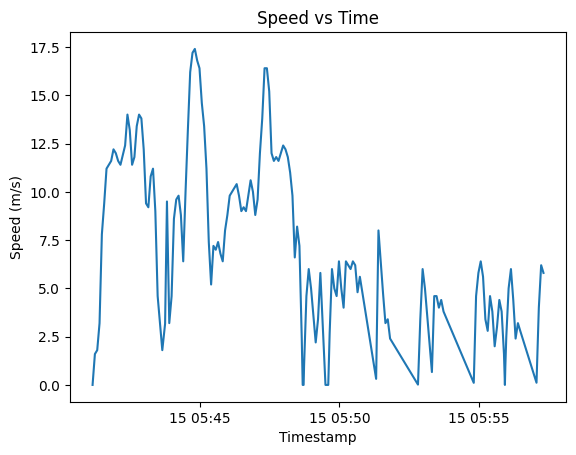

In [17]:
# plot the SPEED column against the ACT_TIME (timestamp) column
plt.plot(df['TIMESTAMP'], df['SPEED'])
plt.xlabel('Timestamp')
plt.ylabel('Speed (m/s)')
plt.title('Speed vs Time')
plt.show()

## Get Max, Min, and Avg Speed

In [18]:
df.describe()

,EVENT_NO_TRIP,VEHICLE_ID,METERS,ACT_TIME,GPS_LONGITUDE,GPS_LATITUDE,SPEED
count,161.0,161.0,161.000000,161.000000,161.000000,161.000000,161.000000
mean,259172515.0,4223.0,3589.186335,20901.670807,-122.666642,45.514643,7.182316
std,0.0,0.0,1810.681478,276.646724,0.010093,0.010566,4.443425
min,259172515.0,4223.0,40.000000,20469.000000,-122.677585,45.493070,0.000000
25%,259172515.0,4223.0,1933.000000,20674.000000,-122.675990,45.503155,3.800000
50%,259172515.0,4223.0,4165.000000,20874.000000,-122.669730,45.517902,6.400000
75%,259172515.0,4223.0,5208.000000,21094.000000,-122.660792,45.523190,10.800000
max,259172515.0,4223.0,5918.000000,21439.000000,-122.647997,45.528065,17.400000


In [19]:
df = df.drop(['OPD_DATE', 'ACT_TIME'], axis=1)

# Large Dataset

In [20]:
# downloads the .csv file from google drive only if it's not already in directory
file_path = "/content/bc_veh4223_230215.csv"
if os.path.isfile(file_path) == False:
  !gdown 1Q-Ae2d48tGxMOzjeGW2_115UfgPNttc7

large_df = pd.read_csv(file_path, usecols=needed_cols, low_memory=False)

In [21]:
large_df = Get_Timestamp(large_df)
large_df = Get_Speed(large_df)

In [22]:
large_df.head(10)

,EVENT_NO_TRIP,OPD_DATE,VEHICLE_ID,METERS,ACT_TIME,GPS_LONGITUDE,GPS_LATITUDE,TIMESTAMP,SPEED
0,259173279,2023-02-15,4223,194493,71279,-122.679572,45.517122,2023-02-15 19:47:59,0.000000
1,259173279,2023-02-15,4223,194525,71284,-122.679408,45.517392,2023-02-15 19:48:04,6.400000
2,259173279,2023-02-15,4223,194562,71290,-122.679227,45.517700,2023-02-15 19:48:10,6.166667
3,259173279,2023-02-15,4223,194598,71295,-122.679048,45.517998,2023-02-15 19:48:15,7.200000
4,259173279,2023-02-15,4223,194628,71300,-122.678888,45.518255,2023-02-15 19:48:20,6.000000
5,259173279,2023-02-15,4223,194659,71305,-122.678753,45.518518,2023-02-15 19:48:25,6.200000
6,259173279,2023-02-15,4223,194683,71309,-122.678687,45.518737,2023-02-15 19:48:29,6.000000
7,259173279,2023-02-15,4223,194696,71315,-122.678657,45.518853,2023-02-15 19:48:35,2.166667
8,259173279,2023-02-15,4223,194721,71319,-122.678542,45.519072,2023-02-15 19:48:39,6.250000
9,259173279,2023-02-15,4223,194750,71324,-122.678370,45.519307,2023-02-15 19:48:44,5.800000


## What is the Max Speed of Vehicle ID 4223?

In [23]:
max_speed = Get_Max_Speed_For_ID(large_df, 4223)
max_speed

17.4

## When Did this Max Speed Happen?

In [24]:
speed_dates = Get_Speed_Date(large_df, 4223, max_speed)
speed_dates

2356   2023-02-15
6573   2023-02-15
Name: OPD_DATE, dtype: datetime64[ns]

## What is The Mean Speed for This Date?

In [25]:
mean_speed1 = Get_Mean_Speed_For_Date(large_df, speed_dates.iloc[0])
mean_speed1

7.143026172636277

In [26]:
mean_speed2 = Get_Mean_Speed_For_Date(large_df, speed_dates.iloc[1])
mean_speed2

7.143026172636277

# Full Dataset

In [27]:
# downloads the .csv file from google drive only if it's not already in directory
file_path = "/content/bc_230215.csv"
if os.path.isfile(file_path) == False:
  !gdown 1pT7Gk24kodlZn7L2UxOT6S4gKTfDNTdP

full_df = pd.read_csv(file_path, usecols=needed_cols, low_memory=False)

In [28]:
full_df = Get_Timestamp(full_df)
full_df = Get_Speed(full_df)

In [29]:
full_df.head(10)

,EVENT_NO_TRIP,OPD_DATE,VEHICLE_ID,METERS,ACT_TIME,GPS_LONGITUDE,GPS_LATITUDE,TIMESTAMP,SPEED
0,259173279,2023-02-15,4223,194493,71279,-122.679572,45.517122,2023-02-15 19:47:59,0.000000
1,259173279,2023-02-15,4223,194525,71284,-122.679408,45.517392,2023-02-15 19:48:04,6.400000
2,259173279,2023-02-15,4223,194562,71290,-122.679227,45.517700,2023-02-15 19:48:10,6.166667
3,259173279,2023-02-15,4223,194598,71295,-122.679048,45.517998,2023-02-15 19:48:15,7.200000
4,259173279,2023-02-15,4223,194628,71300,-122.678888,45.518255,2023-02-15 19:48:20,6.000000
5,259173279,2023-02-15,4223,194659,71305,-122.678753,45.518518,2023-02-15 19:48:25,6.200000
6,259173279,2023-02-15,4223,194683,71309,-122.678687,45.518737,2023-02-15 19:48:29,6.000000
7,259173279,2023-02-15,4223,194696,71315,-122.678657,45.518853,2023-02-15 19:48:35,2.166667
8,259173279,2023-02-15,4223,194721,71319,-122.678542,45.519072,2023-02-15 19:48:39,6.250000
9,259173279,2023-02-15,4223,194750,71324,-122.678370,45.519307,2023-02-15 19:48:44,5.800000


## Get Max Speed ID

In [30]:
max_speed_row = full_df[full_df['SPEED']==full_df['SPEED'].max()]
max_speed_row

,EVENT_NO_TRIP,OPD_DATE,VEHICLE_ID,METERS,ACT_TIME,GPS_LONGITUDE,GPS_LATITUDE,TIMESTAMP,SPEED
63774,259159619,2023-02-15,2940,157243,64451,-122.792802,45.483517,2023-02-15 17:54:11,1568.346154


In [31]:
max_speed_ID = max_speed_row['VEHICLE_ID'].iloc[0]
max_speed_ID

2940

In [48]:
max_speed = Get_Max_Speed_For_ID(full_df, max_speed_ID)
max_speed

1568.3461538461538

## Where and When Did This Max Speed Occur?

In [49]:
speed_dates = Get_Speed_Date(full_df, max_speed_ID, max_speed)
speed_dates

63774   2023-02-15
Name: OPD_DATE, dtype: datetime64[ns]

In [56]:
speed_loc = Get_Speed_Loc(full_df, max_speed_ID, max_speed)
speed_loc

(-122.792802, 45.483517)

## Which vehicle had the fastest mean speed for any single trip on this day?

In [57]:
max_speed_ID

2940

## Which vehicle and which trip achieved this fastest average speed?

In [ ]:
max_speed_row = full_df[full_df['SPEED']==full_df['SPEED'].max()]
max_speed_row